In [1]:
import keras
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from itertools import count
from sklearn.metrics import accuracy_score
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Dropout, Flatten, Activation, Input, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.callbacks import EarlyStopping
from scipy.stats import pearsonr
from tqdm import tqdm

Using TensorFlow backend.


In [0]:
BATCH_SIZE = 128
EPOCHS = 20
IMAGE_SIZE = 28
NUM_CLASSES = 10
MODEL_ADDITION_DELTA = 0.01
MODEL_ADDITION_PATIENCE = 3
MODEL_NAME = "MNIST_augment"
PATH = ""

In [0]:
rotation_range = 10
width_shift_range = 0.1
height_shift_range = 0.1
brightness_range = (0.5,1.0)
zoom_range = 0.2
horizontal_flip = True

# Set seeds

In [0]:
np.random.seed(1)
tf.random.set_seed(1)

# Preprocess

In [0]:
def preprocess(imgs):
    
    return imgs.reshape(imgs.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)

In [6]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = preprocess(x_train)
x_test = preprocess(x_test)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

11493376/11490434 [==============================] - 2s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [0]:
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)

In [0]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [0]:
# Split the data
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, shuffle= True)

#Data generators


In [0]:
datagen_rotation = ImageDataGenerator(rotation_range=rotation_range)
datagen_width_shift = ImageDataGenerator(width_shift_range=width_shift_range)
datagen_height_shift = ImageDataGenerator(height_shift_range=height_shift_range)
datagen_brightness = ImageDataGenerator(brightness_range=brightness_range)
datagen_zoom = ImageDataGenerator(zoom_range=zoom_range)
datagen_hflip = ImageDataGenerator(horizontal_flip=horizontal_flip)

In [0]:
datagens = []
datagens.append(datagen_rotation)
datagens.append(datagen_width_shift)
datagens.append(datagen_height_shift)
datagens.append(datagen_brightness)
datagens.append(datagen_zoom)
datagens.append(datagen_hflip)

# Model

In [0]:
def MNISTmodel(imsize, num_classes, num_channels):
    inputs = Input((imsize,imsize,num_channels))
    x = Conv2D(filters=16, kernel_size=(3,3), activation='relu',strides = 2)(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same')(x)
    x = Conv2D(filters=16, kernel_size=(1,1), activation='relu', padding='valid')(x)
    x = Conv2D(filters=10, kernel_size=(1,1),strides=(1,1), padding='valid')(x)
    x = GlobalAveragePooling2D()(x)
    outputs = Activation('softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)

    optimizer = keras.optimizers.Adam(learning_rate = 1e-04)

    model.compile(loss='categorical_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])
    return model

# Predict

In [0]:
def predict(models, X, Y):
    predictions = []

    for m in tqdm(models):
        predictions.append(np.argmax(m.predict(X), axis=1))

    prediction = np.transpose(predictions)
    prediction = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=prediction)

    return accuracy_score(prediction, np.argmax(Y, axis=1))

# Train

In [14]:
models = []
accuracies = [0]
patience = 0

for i in range(len(datagens)):

    print(f"Train model {i}")

    datagen = datagens[i].flow(x_train,y_train, batch_size = BATCH_SIZE) 
    model = MNISTmodel(IMAGE_SIZE, NUM_CLASSES, 1)

    es = EarlyStopping(min_delta=0.01, patience=3)
    model.fit_generator(datagen,
                        epochs = EPOCHS,
                        validation_data = (x_test,y_test),
                        shuffle = True,
                        callbacks=[es])
    
    model.save_weights(PATH + MODEL_NAME + f"_weights-{i}.h5" )
    models.append(model)

    acc = predict(models, x_val, y_val)
    accuracies.append(acc)

    print(f"Model: {i} added. Resulting score: {acc}")

Train model 0
Epoch 1/20
375/375 [==============================] - 15s 41ms/step - loss: 2.3098 - accuracy: 0.2058 - val_loss: 2.2774 - val_accuracy: 0.2112
Epoch 2/20
375/375 [==============================] - 8s 22ms/step - loss: 2.2272 - accuracy: 0.2590 - val_loss: 2.1971 - val_accuracy: 0.2676
Epoch 3/20
375/375 [==============================] - 8s 22ms/step - loss: 2.1686 - accuracy: 0.2850 - val_loss: 2.1255 - val_accuracy: 0.3058
Epoch 4/20
375/375 [==============================] - 9s 23ms/step - loss: 2.1005 - accuracy: 0.3119 - val_loss: 2.0480 - val_accuracy: 0.3212
Epoch 5/20
375/375 [==============================] - 8s 22ms/step - loss: 2.0253 - accuracy: 0.3288 - val_loss: 1.9690 - val_accuracy: 0.3457
Epoch 6/20
375/375 [==============================] - 8s 22ms/step - loss: 1.9556 - accuracy: 0.3499 - val_loss: 1.9034 - val_accuracy: 0.3709
Epoch 7/20
375/375 [==============================] - 8s 22ms/step - loss: 1.8994 - accuracy: 0.3693 - val_loss: 1.8495 - val_a

100%|██████████| 1/1 [00:00<00:00,  2.04it/s]


Model: 0 added. Resulting score: 0.4696666666666667
Train model 1
Epoch 1/20
375/375 [==============================] - 9s 23ms/step - loss: 2.3494 - accuracy: 0.1079 - val_loss: 2.2998 - val_accuracy: 0.0974
Epoch 2/20
375/375 [==============================] - 9s 23ms/step - loss: 2.2759 - accuracy: 0.1912 - val_loss: 2.2577 - val_accuracy: 0.2146
Epoch 3/20
375/375 [==============================] - 9s 23ms/step - loss: 2.2270 - accuracy: 0.2612 - val_loss: 2.1909 - val_accuracy: 0.2824
Epoch 4/20
375/375 [==============================] - 9s 23ms/step - loss: 2.1589 - accuracy: 0.2932 - val_loss: 2.1094 - val_accuracy: 0.3277
Epoch 5/20
375/375 [==============================] - 9s 23ms/step - loss: 2.0789 - accuracy: 0.3186 - val_loss: 2.0252 - val_accuracy: 0.3358
Epoch 6/20
375/375 [==============================] - 9s 23ms/step - loss: 1.9991 - accuracy: 0.3292 - val_loss: 1.9455 - val_accuracy: 0.3456
Epoch 7/20
375/375 [==============================] - 9s 23ms/step - loss: 1

100%|██████████| 2/2 [00:00<00:00,  2.26it/s]


Model: 1 added. Resulting score: 0.46
Train model 2
Epoch 1/20
375/375 [==============================] - 9s 23ms/step - loss: 2.3242 - accuracy: 0.0729 - val_loss: 2.2981 - val_accuracy: 0.1340
Epoch 2/20
375/375 [==============================] - 8s 22ms/step - loss: 2.2712 - accuracy: 0.1604 - val_loss: 2.2572 - val_accuracy: 0.1823
Epoch 3/20
375/375 [==============================] - 9s 23ms/step - loss: 2.2240 - accuracy: 0.2047 - val_loss: 2.1950 - val_accuracy: 0.2094
Epoch 4/20
375/375 [==============================] - 9s 23ms/step - loss: 2.1669 - accuracy: 0.2543 - val_loss: 2.1259 - val_accuracy: 0.2347
Epoch 5/20
375/375 [==============================] - 8s 23ms/step - loss: 2.0992 - accuracy: 0.2778 - val_loss: 2.0532 - val_accuracy: 0.2804
Epoch 6/20
375/375 [==============================] - 8s 23ms/step - loss: 2.0324 - accuracy: 0.3021 - val_loss: 1.9852 - val_accuracy: 0.2997
Epoch 7/20
375/375 [==============================] - 9s 23ms/step - loss: 1.9693 - accura

100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Model: 2 added. Resulting score: 0.48125
Train model 3
Epoch 1/20
375/375 [==============================] - 8s 21ms/step - loss: 2.3037 - accuracy: 0.1781 - val_loss: 2.3154 - val_accuracy: 0.1135
Epoch 2/20
375/375 [==============================] - 8s 20ms/step - loss: 2.2454 - accuracy: 0.2388 - val_loss: 2.3390 - val_accuracy: 0.1135
Epoch 3/20
375/375 [==============================] - 8s 20ms/step - loss: 2.1931 - accuracy: 0.2670 - val_loss: 2.3911 - val_accuracy: 0.1135
Epoch 4/20
375/375 [==============================] - 8s 20ms/step - loss: 2.1277 - accuracy: 0.2860 - val_loss: 2.4909 - val_accuracy: 0.1135


100%|██████████| 4/4 [00:01<00:00,  2.31it/s]


Model: 3 added. Resulting score: 0.4673333333333333
Train model 4
Epoch 1/20
375/375 [==============================] - 8s 21ms/step - loss: 2.3224 - accuracy: 0.1388 - val_loss: 2.2824 - val_accuracy: 0.2189
Epoch 2/20
375/375 [==============================] - 8s 21ms/step - loss: 2.2496 - accuracy: 0.2172 - val_loss: 2.2224 - val_accuracy: 0.2325
Epoch 3/20
375/375 [==============================] - 8s 21ms/step - loss: 2.1974 - accuracy: 0.2463 - val_loss: 2.1513 - val_accuracy: 0.2673
Epoch 4/20
375/375 [==============================] - 8s 21ms/step - loss: 2.1312 - accuracy: 0.2694 - val_loss: 2.0686 - val_accuracy: 0.2998
Epoch 5/20
375/375 [==============================] - 8s 21ms/step - loss: 2.0595 - accuracy: 0.2840 - val_loss: 1.9859 - val_accuracy: 0.3283
Epoch 6/20
375/375 [==============================] - 8s 21ms/step - loss: 1.9870 - accuracy: 0.3007 - val_loss: 1.8984 - val_accuracy: 0.3610
Epoch 7/20
375/375 [==============================] - 8s 21ms/step - loss: 1

100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


Model: 4 added. Resulting score: 0.47158333333333335
Train model 5
Epoch 1/20
375/375 [==============================] - 3s 7ms/step - loss: 2.3212 - accuracy: 0.0984 - val_loss: 2.2890 - val_accuracy: 0.1385
Epoch 2/20
375/375 [==============================] - 2s 6ms/step - loss: 2.2424 - accuracy: 0.1810 - val_loss: 2.2183 - val_accuracy: 0.2622
Epoch 3/20
375/375 [==============================] - 3s 7ms/step - loss: 2.1868 - accuracy: 0.2875 - val_loss: 2.1505 - val_accuracy: 0.3221
Epoch 4/20
375/375 [==============================] - 2s 6ms/step - loss: 2.1247 - accuracy: 0.3129 - val_loss: 2.0837 - val_accuracy: 0.3335
Epoch 5/20
375/375 [==============================] - 2s 6ms/step - loss: 2.0574 - accuracy: 0.3228 - val_loss: 2.0158 - val_accuracy: 0.3409
Epoch 6/20
375/375 [==============================] - 2s 6ms/step - loss: 1.9894 - accuracy: 0.3342 - val_loss: 1.9487 - val_accuracy: 0.3536
Epoch 7/20
375/375 [==============================] - 2s 6ms/step - loss: 1.9249 

100%|██████████| 6/6 [00:02<00:00,  2.24it/s]

Model: 5 added. Resulting score: 0.4865833333333333


# Results

# Accuracy vs nr of models
Visualizing the accuracy vs the number of models in the ensemble

In [15]:
accuracy_df = pd.DataFrame(accuracies, columns=["Accuracy"])
accuracy_df.insert(1, "Nr of models", accuracy_df.index)

display(accuracy_df)

accuracy_df.to_csv(PATH + MODEL_NAME + "_accuracy.csv")

,Accuracy,Nr of models
0,0.000000,0
1,0.469667,1
2,0.460000,2
3,0.481250,3
4,0.467333,4
5,0.471583,5
6,0.486583,6


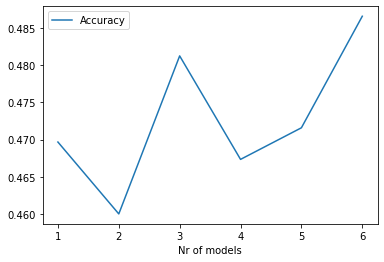

In [16]:
import matplotlib.pyplot as plt

# remove first row
accuracy_df = accuracy_df.iloc[1:]

accuracy_df.plot(x="Nr of models", y="Accuracy", xticks=accuracy_df["Nr of models"])
plt.show()

## Accuracy
The final accuracy of the ensamble on the test set

In [17]:
print("Accuracy: " + str(predict(models, x_test, y_test)))

100%|██████████| 6/6 [00:02<00:00,  2.80it/s]

Accuracy: 0.4944


## Correlation between models

In [18]:
predictions = []

for m in tqdm(models):
    predictions.append(np.argmax(m.predict(x_test), axis=1))

100%|██████████| 6/6 [00:02<00:00,  2.82it/s]


In [19]:
correlation_matrix = []

for ix, x in enumerate(predictions):
  row = []
  
  for iy, y in enumerate(predictions):
    if (ix == iy):
      row.append(np.nan)
    else:
      row.append(pearsonr(x,y)[0])

  correlation_matrix.append(row)

correlation_matrix = np.array(correlation_matrix)
display(pd.DataFrame(correlation_matrix))
print("Average correlation: " + str(np.nanmean(correlation_matrix.flatten())))

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


,0,1,2,3,4,5
0,NaN,0.560250,0.559921,NaN,0.624712,0.629930
1,0.560250,NaN,0.547756,NaN,0.581776,0.525111
2,0.559921,0.547756,NaN,NaN,0.556699,0.567642
3,NaN,NaN,NaN,NaN,NaN,NaN
4,0.624712,0.581776,0.556699,NaN,NaN,0.510010
5,0.629930,0.525111,0.567642,NaN,0.510010,NaN


Average correlation: 0.5663806103764353
